# Study 2: Statistical Analysis of Creativity Metrics
## Comparing Dyad vs. Triad Facilitation Conditions

**Research Questions:**
- **RQ3**: How does facilitation model affect verbal creativity across four dimensions?
  - **H3**: Triad shows higher fluency than dyad
  - **H4**: Triad shows higher flexibility than dyad
  - **H5**: Triad shows higher elaboration than dyad
  - **H6**: Triad shows higher originality than dyad

**Author**: Dotun Olutunbi
**Date**: February 2026 

## Setup: Import Libraries and Load Data

In [ ]:
# Run the comparison merge script from the same folder as this notebook.
import runpy
runpy.run_path("merge_results_for_comparison.py", run_name="__main__")

Runs the Claude's coding script

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind, shapiro, levene, normaltest
from scipy.stats import spearmanr, pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [7]:
# Load your JSON data
# IMPORTANT: Replace 'your_data.json' with the actual path to your file
with open('../data/coded/creativity_metrics_summary.json', 'r') as f:
    data_list = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data_list)

print(f"Data loaded: {len(df)} sessions")
print(f"\nColumns: {list(df.columns)}")
df.head()

Data loaded: 61 sessions

Columns: ['session', 'file_name', 'fluency', 'flexibility', 'elaboration_total', 'elaboration_density', 'categories_used', 'unclear_audio', 'very_short_story', 'very_long_story', 'unusual_structure', 'quality_notes', 'descriptors_in_stage_1_count', 'descriptors_repeated_in_stage_2_count', 'new_elaborations_in_stage_2', 'new_elaborations_count']


,session,file_name,fluency,flexibility,elaboration_total,elaboration_density,categories_used,unclear_audio,very_short_story,very_long_story,unusual_structure,quality_notes,descriptors_in_stage_1_count,descriptors_repeated_in_stage_2_count,new_elaborations_in_stage_2,new_elaborations_count
0,dyad,TUEPM23_coded.json,10,4,0,0.00,"character, action, goal, internal_state",False,False,False,True,Story told through responses to robot prompts ...,0,0,,0
1,triad,WEDPM26_coded.json,4,3,1,0.25,"character, action, internal_state",False,True,False,False,Very brief story with minimal elaboration. Chi...,0,0,probably,1
2,triad,WEDPM22_coded.json,12,4,2,0.17,"character, action, internal_state, outcome",False,False,False,False,Well-structured narrative with clear sequence ...,6,2,"for his supper, that the cat ran away",2
3,dyad,THURPM30_coded.json,5,2,0,0.00,"internal_state, action",False,True,False,True,"Very brief responses, mostly single words or s...",0,0,,0
4,dyad,THURAM13_coded.json,1,1,0,0.00,internal_state,False,True,False,True,"Child provided minimal story continuation, mos...",4,0,,0


## PHASE 1: Preliminary Data Checks
### 1.1 Sample Characteristics

In [8]:
# Sample size by condition
print("-"*30)
print("SAMPLE CHARACTERISTICS")
print("="*30)

condition_counts = df['session'].value_counts()
print(f"\nSample Size by Condition:")
print(condition_counts)
print(f"\nTotal N = {len(df)}")

# Calculate percentages
for condition in ['dyad', 'triad']:
    n = len(df[df['session'] == condition])
    pct = (n / len(df)) * 100
    print(f"{condition.capitalize()}: n = {n} ({pct:.1f}%)")

------------------------------
SAMPLE CHARACTERISTICS

Sample Size by Condition:
session
dyad     32
triad    29
Name: count, dtype: int64

Total N = 61
Dyad: n = 32 (52.5%)
Triad: n = 29 (47.5%)


In [9]:
# Descriptive statistics by condition for all creativity metrics
creativity_vars = ['fluency', 'flexibility', 'elaboration_total', 'elaboration_density']

print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS BY CONDITION")
print("="*60)

for var in creativity_vars:
    print(f"\n{var.upper().replace('_', ' ')}:")
    print("-" * 60)
    
    dyad_stats = df[df['session'] == 'dyad'][var].describe()
    triad_stats = df[df['session'] == 'triad'][var].describe()
    
    comparison_df = pd.DataFrame({
        'Dyad': dyad_stats,
        'Triad': triad_stats
    })
    
    print(comparison_df.round(2))


DESCRIPTIVE STATISTICS BY CONDITION

FLUENCY:
------------------------------------------------------------
        Dyad  Triad
count  32.00  29.00
mean    7.41  10.24
std     4.05   5.32
min     0.00   3.00
25%     4.75   6.00
50%     7.00  10.00
75%     9.25  12.00
max    17.00  31.00

FLEXIBILITY:
------------------------------------------------------------
        Dyad  Triad
count  32.00  29.00
mean    3.47   4.45
std     1.41   1.18
min     0.00   2.00
25%     2.00   4.00
50%     4.00   4.00
75%     5.00   6.00
max     6.00   6.00

ELABORATION TOTAL:
------------------------------------------------------------
        Dyad  Triad
count  32.00  29.00
mean    1.50   3.52
std     1.61   3.46
min     0.00   0.00
25%     0.00   1.00
50%     1.00   2.00
75%     2.00   4.00
max     6.00  15.00

ELABORATION DENSITY:
------------------------------------------------------------
        Dyad  Triad
count  32.00  29.00
mean    0.20   0.32
std     0.23   0.19
min     0.00   0.00
25%     0.00 

### 1.2 Data Quality Checks

In [11]:
# Check for quality flags
print("\n" + "="*60)
print("DATA QUALITY FLAGS")
print("="*60)

quality_flags = ['unclear_audio', 'very_short_story', 'very_long_story', 'unusual_structure']

for flag in quality_flags:
    count = df[flag].sum()
    pct = (count / len(df)) * 100
    print(f"{flag.replace('_', ' ').title()}: {count} ({pct:.1f}%)")
    
    # By condition
    dyad_count = df[df['session'] == 'dyad'][flag].sum()
    triad_count = df[df['session'] == 'triad'][flag].sum()
    print(f"  Dyad: {dyad_count}, Triad: {triad_count}")

# Consider creating a 'flagged' variable for sensitivity analysis
df['any_quality_flag'] = df[quality_flags].any(axis=1)
print(f"\nTotal sessions with any quality flag: {df['any_quality_flag'].sum()} ({(df['any_quality_flag'].sum()/len(df)*100):.1f}%)")


DATA QUALITY FLAGS
Unclear Audio: 4 (6.6%)
  Dyad: 1, Triad: 3
Very Short Story: 26 (42.6%)
  Dyad: 17, Triad: 9
Very Long Story: 0 (0.0%)
  Dyad: 0, Triad: 0
Unusual Structure: 15 (24.6%)
  Dyad: 11, Triad: 4

Total sessions with any quality flag: 35 (57.4%)


### 1.3 Normality Testing

In [12]:
# Test normality for each creativity variable by condition
print("\n" + "-"*30)
print("NORMALITY TESTS (Shapiro-Wilk)")
print("="*30)
print("Note: p < .05 indicates violation of normality assumption\n")

normality_results = {}

for var in creativity_vars:
    print(f"\n{var.upper().replace('_', ' ')}:")
    print("-" * 30)
    
    for condition in ['dyad', 'triad']:
        data = df[df['session'] == condition][var].dropna()
        
        if len(data) > 3:  # Shapiro-Wilk requires n > 3
            stat, p = shapiro(data)
            normality_results[f"{var}_{condition}"] = {'stat': stat, 'p': p, 'normal': p > 0.05}
            
            result = " Normal" if p > 0.05 else " Non-normal"
            print(f"  {condition.capitalize():6} : W = {stat:.4f}, p = {p:.4f} {result}")
        else:
            print(f"  {condition.capitalize():6} : Insufficient data (n={len(data)})")


------------------------------
NORMALITY TESTS (Shapiro-Wilk)
Note: p < .05 indicates violation of normality assumption


FLUENCY:
------------------------------
  Dyad   : W = 0.9785, p = 0.7544  Normal
  Triad  : W = 0.8188, p = 0.0002  Non-normal

FLEXIBILITY:
------------------------------
  Dyad   : W = 0.9307, p = 0.0409  Non-normal
  Triad  : W = 0.8788, p = 0.0032  Non-normal

ELABORATION TOTAL:
------------------------------
  Dyad   : W = 0.8419, p = 0.0003  Non-normal
  Triad  : W = 0.7706, p = 0.0000  Non-normal

ELABORATION DENSITY:
------------------------------
  Dyad   : W = 0.8542, p = 0.0005  Non-normal
  Triad  : W = 0.9511, p = 0.1950  Normal


dyad min = 0 max = 17 max bin count = 7
triad min = 3 max = 31 max bin count = 9
dyad min = 0 max = 6 max bin count = 8
triad min = 2 max = 6 max bin count = 11
dyad min = 0 max = 6 max bin count = 12
triad min = 0 max = 15 max bin count = 10
dyad min = 0.0 max = 0.83 max bin count = 13
triad min = 0.0 max = 0.73 max bin count = 5


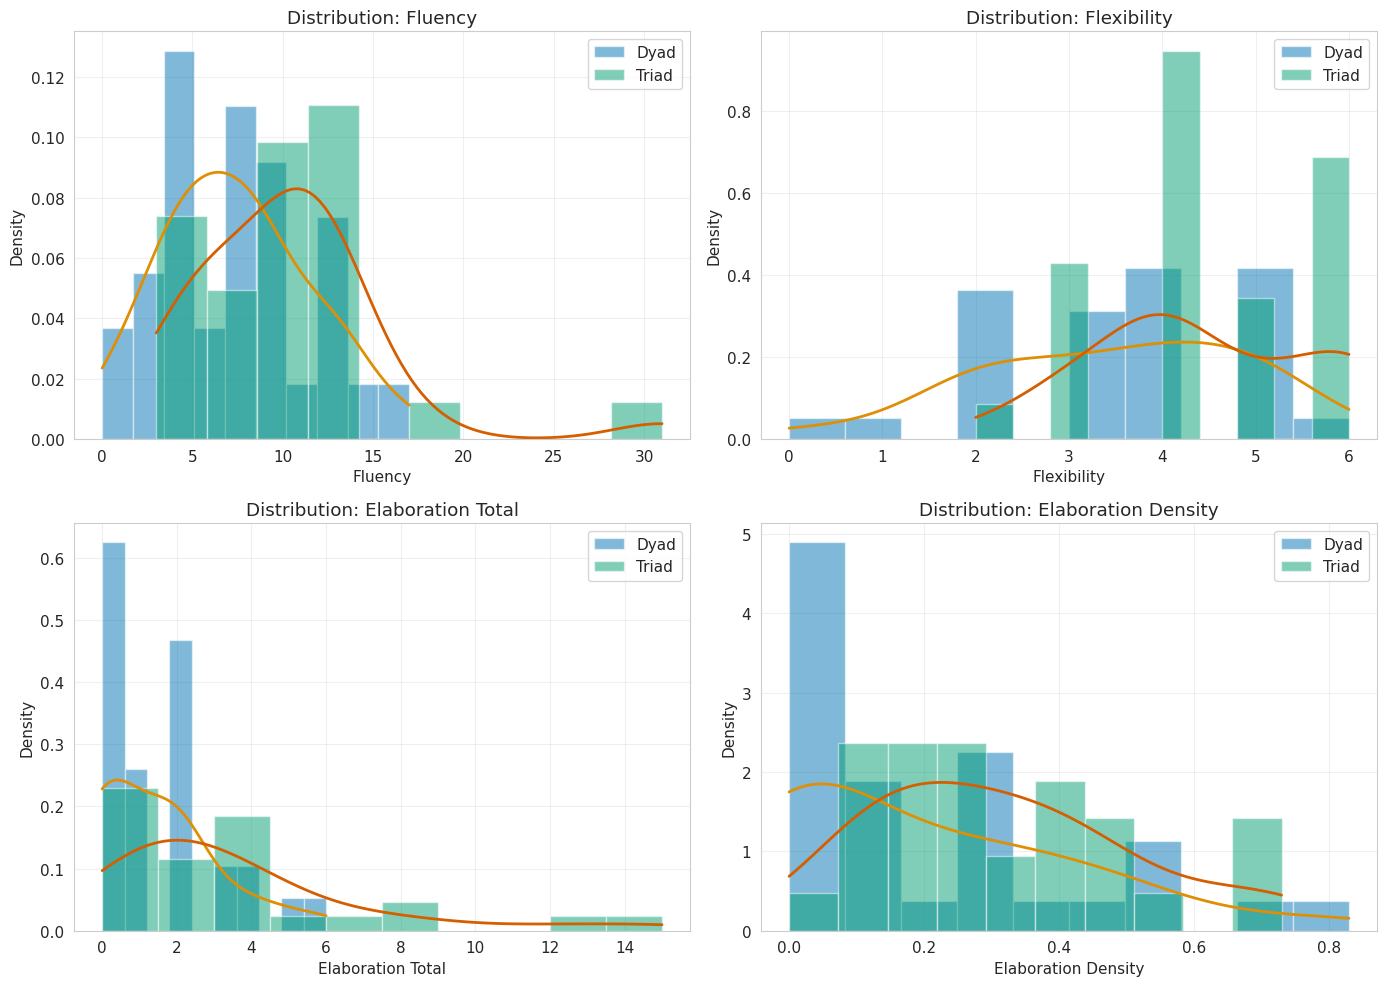


Distribution plots saved as 'distributions_by_condition.png'


In [21]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, var in enumerate(creativity_vars):
    ax = axes[idx]
    
    # Histogram with KDE overlay
    for condition in ['dyad', 'triad']:
        data = df[df['session'] == condition][var].dropna()
        counts, edges = np.histogram(data, bins=10, density=False)
        print(condition, "min =", data.min(), "max =", data.max(), "max bin count =", counts.max())
        ax.hist(data, alpha=0.5, label=condition.capitalize(), bins=10, density=True)
        
        # Add KDE if enough data points
        if len(data) > 2:
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(data)
            x_range = np.linspace(data.min(), data.max(), 100)
            ax.plot(x_range, kde(x_range), linewidth=2)
    
    ax.set_title(f'Distribution: {var.replace("_", " ").title()}')
    ax.set_xlabel(var.replace('_', ' ').title())
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distributions_by_condition.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDistribution plots saved as 'distributions_by_condition.png'")

### 1.4 Variance Homogeneity Testing

In [22]:
# Levene's test for equality of variances (spreads) between conditions
print("\n" + "="*60)
print("VARIANCE HOMOGENEITY TESTS (Levene's Test)")
print("="*60)
print("Note: p < .05 indicates violation of equal variance assumption\n")

variance_results = {}

for var in creativity_vars:
    dyad_data = df[df['session'] == 'dyad'][var].dropna()
    triad_data = df[df['session'] == 'triad'][var].dropna()
    
    if len(dyad_data) > 0 and len(triad_data) > 0:
        stat, p = levene(dyad_data, triad_data)
        variance_results[var] = {'stat': stat, 'p': p, 'equal': p > 0.05}
        
        result = "✓ Equal variances" if p > 0.05 else "✗ Unequal variances"
        print(f"{var.replace('_', ' ').title():25} : F = {stat:.4f}, p = {p:.4f} {result}")


VARIANCE HOMOGENEITY TESTS (Levene's Test)
Note: p < .05 indicates violation of equal variance assumption

Fluency                   : F = 0.1630, p = 0.6879 ✓ Equal variances
Flexibility               : F = 0.9469, p = 0.3345 ✓ Equal variances
Elaboration Total         : F = 3.2596, p = 0.0761 ✓ Equal variances
Elaboration Density       : F = 0.4745, p = 0.4936 ✓ Equal variances


### 1.5 Statistical Test Selection Decision

In [23]:
# Create decision matrix for test selection
print("\n" + "="*60)
print("TEST SELECTION DECISION MATRIX")
print("="*60)

test_decisions = {}

for var in creativity_vars:
    # Check if both conditions are normal
    dyad_normal = normality_results.get(f"{var}_dyad", {}).get('normal', False)
    triad_normal = normality_results.get(f"{var}_triad", {}).get('normal', False)
    both_normal = dyad_normal and triad_normal
    
    # Check variance equality
    equal_var = variance_results.get(var, {}).get('equal', False)
    
    # Decision logic
    if both_normal and equal_var:
        test = "Independent t-test (equal variance)"
        test_code = "ttest_equal"
    elif both_normal and not equal_var:
        test = "Welch's t-test (unequal variance)"
        test_code = "ttest_welch"
    else:
        test = "Mann-Whitney U test (non-parametric)"
        test_code = "mann_whitney"
    
    test_decisions[var] = test_code
    
    print(f"\n{var.replace('_', ' ').title()}:")
    print(f"  Normality: Dyad {'✓' if dyad_normal else '✗'}, Triad {'✓' if triad_normal else '✗'}")
    print(f"  Equal variance: {'✓' if equal_var else '✗'}")
    print(f"  → Selected test: {test}")

print("\n" + "="*60)


TEST SELECTION DECISION MATRIX

Fluency:
  Normality: Dyad ✓, Triad ✗
  Equal variance: ✓
  → Selected test: Mann-Whitney U test (non-parametric)

Flexibility:
  Normality: Dyad ✗, Triad ✗
  Equal variance: ✓
  → Selected test: Mann-Whitney U test (non-parametric)

Elaboration Total:
  Normality: Dyad ✗, Triad ✗
  Equal variance: ✓
  → Selected test: Mann-Whitney U test (non-parametric)

Elaboration Density:
  Normality: Dyad ✗, Triad ✓
  Equal variance: ✓
  → Selected test: Mann-Whitney U test (non-parametric)



In [26]:
# Function defined to calculate Cohen's d effect size
def cohens_d(group1, group2):
    """
    Calculate Cohen's d effect size
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group2) - np.mean(group1)) / pooled_std

# Function to calculate effect size r for Mann-Whitney
def effect_size_r(u_statistic, n1, n2):
    """
    Calculate effect size r for Mann-Whitney U test
    r = Z / sqrt(N)
    """
    z = (u_statistic - (n1*n2/2)) / np.sqrt(n1*n2*(n1+n2+1)/12)
    r = abs(z) / np.sqrt(n1 + n2)
    return r

# Function to interpret effect size
def interpret_effect_size(d_or_r, metric='d'):
    """
    Interpret effect size magnitude (Cohen, 1988)
    """
    abs_value = abs(d_or_r)
    if metric == 'd':
        if abs_value < 0.2:
            return "negligible"
        elif abs_value < 0.5:
            return "small"
        elif abs_value < 0.8:
            return "medium"
        else:
            return "large"
    else:  # r
        if abs_value < 0.1:
            return "negligible"
        elif abs_value < 0.3:
            return "small"
        elif abs_value < 0.5:
            return "medium"
        else:
            return "large"

In [25]:
# Run statistical tests for all hypotheses
print("\n" + "="*70)
print("HYPOTHESIS TESTING: CREATIVITY METRICS COMPARISON")
print("="*70)

# Hypothesis mapping
hypothesis_map = {
    'fluency': 'H3',
    'flexibility': 'H4',
    'elaboration_total': 'H5a',
    'elaboration_density': 'H5b'
}

results_summary = []

for var in creativity_vars:
    print(f"\n{'='*70}")
    print(f"{hypothesis_map.get(var, 'H?')}: {var.replace('_', ' ').title()}")
    print(f"Hypothesis: Triad > Dyad")
    print(f"{'='*70}")
    
    # Extract data
    dyad_data = df[df['session'] == 'dyad'][var].dropna()
    triad_data = df[df['session'] == 'triad'][var].dropna()
    
    # Descriptive statistics
    print(f"\nDescriptive Statistics:")
    print(f"  Dyad:  M = {dyad_data.mean():.2f}, SD = {dyad_data.std():.2f}, Mdn = {dyad_data.median():.2f}, n = {len(dyad_data)}")
    print(f"  Triad: M = {triad_data.mean():.2f}, SD = {triad_data.std():.2f}, Mdn = {triad_data.median():.2f}, n = {len(triad_data)}")
    print(f"  Mean Difference (Triad - Dyad): {triad_data.mean() - dyad_data.mean():.2f}")
    
    # Perform appropriate test
    test_type = test_decisions[var]
    
    if test_type in ['ttest_equal', 'ttest_welch']:
        # Independent t-test
        equal_var = (test_type == 'ttest_equal')
        t_stat, p_value_two = ttest_ind(triad_data, dyad_data, equal_var=equal_var)
        p_value_one = p_value_two / 2  # One-tailed test
        
        # Calculate degrees of freedom
        if equal_var:
            df_test = len(dyad_data) + len(triad_data) - 2
        else:
            # Welch-Satterthwaite approximation
            s1_sq = dyad_data.var()
            s2_sq = triad_data.var()
            n1, n2 = len(dyad_data), len(triad_data)
            df_test = ((s1_sq/n1 + s2_sq/n2)**2) / ((s1_sq/n1)**2/(n1-1) + (s2_sq/n2)**2/(n2-1))
        
        # Effect size
        effect = cohens_d(dyad_data, triad_data)
        effect_interp = interpret_effect_size(effect, 'd')
        
        # 95% CI for mean difference
        from scipy.stats import t as t_dist
        se = np.sqrt(dyad_data.var()/len(dyad_data) + triad_data.var()/len(triad_data))
        ci_lower = (triad_data.mean() - dyad_data.mean()) - t_dist.ppf(0.975, df_test) * se
        ci_upper = (triad_data.mean() - dyad_data.mean()) + t_dist.ppf(0.975, df_test) * se
        
        print(f"\nInferential Statistics:")
        test_name = "Independent t-test" if equal_var else "Welch's t-test"
        print(f"  Test: {test_name}")
        print(f"  t({df_test:.1f}) = {t_stat:.3f}")
        print(f"  p (two-tailed) = {p_value_two:.4f}")
        print(f"  p (one-tailed) = {p_value_one:.4f}")
        print(f"  Cohen's d = {effect:.3f} ({effect_interp})")
        print(f"  95% CI for difference: [{ci_lower:.2f}, {ci_upper:.2f}]")
        
        results_summary.append({
            'Variable': var,
            'Hypothesis': hypothesis_map.get(var, 'H?'),
            'Test': test_name,
            'Statistic': f"t({df_test:.1f}) = {t_stat:.3f}",
            'p_two_tailed': p_value_two,
            'p_one_tailed': p_value_one,
            'Effect_Size': f"d = {effect:.3f}",
            'Effect_Magnitude': effect_interp,
            'Mean_Diff': triad_data.mean() - dyad_data.mean(),
            'Supported': p_value_one < 0.05 and t_stat > 0
        })
        
    else:  # Mann-Whitney U test
        u_stat, p_value_two = mannwhitneyu(triad_data, dyad_data, alternative='two-sided')
        u_stat_one, p_value_one = mannwhitneyu(triad_data, dyad_data, alternative='greater')
        
        # Effect size r
        effect = effect_size_r(u_stat, len(dyad_data), len(triad_data))
        effect_interp = interpret_effect_size(effect, 'r')
        
        print(f"\nInferential Statistics:")
        print(f"  Test: Mann-Whitney U test")
        print(f"  U = {u_stat:.1f}")
        print(f"  p (two-tailed) = {p_value_two:.4f}")
        print(f"  p (one-tailed) = {p_value_one:.4f}")
        print(f"  Effect size r = {effect:.3f} ({effect_interp})")
        
        results_summary.append({
            'Variable': var,
            'Hypothesis': hypothesis_map.get(var, 'H?'),
            'Test': 'Mann-Whitney U',
            'Statistic': f"U = {u_stat:.1f}",
            'p_two_tailed': p_value_two,
            'p_one_tailed': p_value_one,
            'Effect_Size': f"r = {effect:.3f}",
            'Effect_Magnitude': effect_interp,
            'Mean_Diff': triad_data.mean() - dyad_data.mean(),
            'Supported': p_value_one < 0.05
        })
    
    # Interpretation
    print(f"\nInterpretation:")
    if results_summary[-1]['Supported']:
        print(f"  ✓ {hypothesis_map.get(var, 'H?')} SUPPORTED: Triad shows significantly higher {var.replace('_', ' ')} than Dyad.")
    else:
        print(f"  ✗ {hypothesis_map.get(var, 'H?')} NOT SUPPORTED: No significant difference between conditions.")

print("\n" + "="*70)


HYPOTHESIS TESTING: CREATIVITY METRICS COMPARISON

H3: Fluency
Hypothesis: Triad > Dyad

Descriptive Statistics:
  Dyad:  M = 7.41, SD = 4.05, Mdn = 7.00, n = 32
  Triad: M = 10.24, SD = 5.32, Mdn = 10.00, n = 29
  Mean Difference (Triad - Dyad): 2.84

Inferential Statistics:
  Test: Mann-Whitney U test
  U = 618.5
  p (two-tailed) = 0.0257
  p (one-tailed) = 0.0128
  Effect size r = 0.286 (small)

Interpretation:
  ✓ H3 SUPPORTED: Triad shows significantly higher fluency than Dyad.

H4: Flexibility
Hypothesis: Triad > Dyad

Descriptive Statistics:
  Dyad:  M = 3.47, SD = 1.41, Mdn = 4.00, n = 32
  Triad: M = 4.45, SD = 1.18, Mdn = 4.00, n = 29
  Mean Difference (Triad - Dyad): 0.98

Inferential Statistics:
  Test: Mann-Whitney U test
  U = 634.5
  p (two-tailed) = 0.0118
  p (one-tailed) = 0.0059
  Effect size r = 0.315 (medium)

Interpretation:
  ✓ H4 SUPPORTED: Triad shows significantly higher flexibility than Dyad.

H5a: Elaboration Total
Hypothesis: Triad > Dyad

Descriptive Stat

### 2.2 Multiple Comparison Adjustment

In [19]:
from statsmodels.stats.multitest import multipletests

print("\n" + "="*70)
print("MULTIPLE COMPARISON ADJUSTMENT")
print("="*70)

# Extract p-values
p_values = [r['p_one_tailed'] for r in results_summary]

# Bonferroni correction
bonferroni_alpha = 0.05 / len(p_values)
bonferroni_reject = [p < bonferroni_alpha for p in p_values]

# FDR correction (Benjamini-Hochberg)
fdr_reject, fdr_pvals, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

print(f"\nNumber of tests: {len(p_values)}")
print(f"Bonferroni-corrected α: {bonferroni_alpha:.4f}")
print(f"\nAdjusted Results:")
print("-" * 70)

for idx, result in enumerate(results_summary):
    print(f"\n{result['Hypothesis']} ({result['Variable']}):")
    print(f"  Original p = {result['p_one_tailed']:.4f}")
    print(f"  FDR-adjusted p = {fdr_pvals[idx]:.4f}")
    print(f"  Bonferroni: {'✓ Significant' if bonferroni_reject[idx] else '✗ Not significant'} (α = {bonferroni_alpha:.4f})")
    print(f"  FDR: {'✓ Significant' if fdr_reject[idx] else '✗ Not significant'} (α = 0.05)")
    
    # Update results
    result['p_fdr_adjusted'] = fdr_pvals[idx]
    result['Significant_FDR'] = fdr_reject[idx]
    result['Significant_Bonferroni'] = bonferroni_reject[idx]

print("\n" + "="*70)
print("RECOMMENDATION: Use FDR correction (Benjamini-Hochberg)")
print("Rationale: More appropriate for exploratory analyses with moderate sample sizes.")
print("="*70)


MULTIPLE COMPARISON ADJUSTMENT

Number of tests: 4
Bonferroni-corrected α: 0.0125

Adjusted Results:
----------------------------------------------------------------------

H3 (fluency):
  Original p = 0.0128
  FDR-adjusted p = 0.0128
  Bonferroni: ✗ Not significant (α = 0.0125)
  FDR: ✓ Significant (α = 0.05)

H4 (flexibility):
  Original p = 0.0059
  FDR-adjusted p = 0.0118
  Bonferroni: ✓ Significant (α = 0.0125)
  FDR: ✓ Significant (α = 0.05)

H5a (elaboration_total):
  Original p = 0.0020
  FDR-adjusted p = 0.0081
  Bonferroni: ✓ Significant (α = 0.0125)
  FDR: ✓ Significant (α = 0.05)

H5b (elaboration_density):
  Original p = 0.0101
  FDR-adjusted p = 0.0128
  Bonferroni: ✓ Significant (α = 0.0125)
  FDR: ✓ Significant (α = 0.05)

RECOMMENDATION: Use FDR correction (Benjamini-Hochberg)
Rationale: More appropriate for exploratory analyses with moderate sample sizes.


### 2.3 Summary Table of All Hypothesis Tests

In [20]:
# Create comprehensive summary table
summary_df = pd.DataFrame(results_summary)

# Format for display
display_df = summary_df[['Hypothesis', 'Variable', 'Test', 'Statistic', 
                         'p_one_tailed', 'p_fdr_adjusted', 'Effect_Size', 
                         'Effect_Magnitude', 'Significant_FDR']].copy()

display_df.columns = ['H', 'Variable', 'Test', 'Statistic', 
                      'p (1-tail)', 'p (FDR)', 'Effect Size', 
                      'Magnitude', 'Sig.']

print("\n" + "="*90)
print("SUMMARY TABLE: HYPOTHESIS TESTING RESULTS")
print("="*90)
print(display_df.to_string(index=False))
print("\nNote: 'Sig.' column indicates significance after FDR correction (α = .05)")
print("="*90)

# Save to CSV
summary_df.to_csv('study2_hypothesis_testing_results.csv', index=False)
print("\nResults saved to 'study2_hypothesis_testing_results.csv'")


SUMMARY TABLE: HYPOTHESIS TESTING RESULTS
  H            Variable           Test Statistic  p (1-tail)  p (FDR) Effect Size Magnitude  Sig.
 H3             fluency Mann-Whitney U U = 618.5    0.012833 0.012833   r = 0.286     small  True
 H4         flexibility Mann-Whitney U U = 634.5    0.005910 0.011821   r = 0.315    medium  True
H5a   elaboration_total Mann-Whitney U U = 660.0    0.002018 0.008074   r = 0.362    medium  True
H5b elaboration_density Mann-Whitney U U = 624.5    0.010075 0.012833   r = 0.297     small  True

Note: 'Sig.' column indicates significance after FDR correction (α = .05)

Results saved to 'study2_hypothesis_testing_results.csv'


## PHASE 3: Visualization of Results
### 3.1 Violin Plots with Individual Data Points

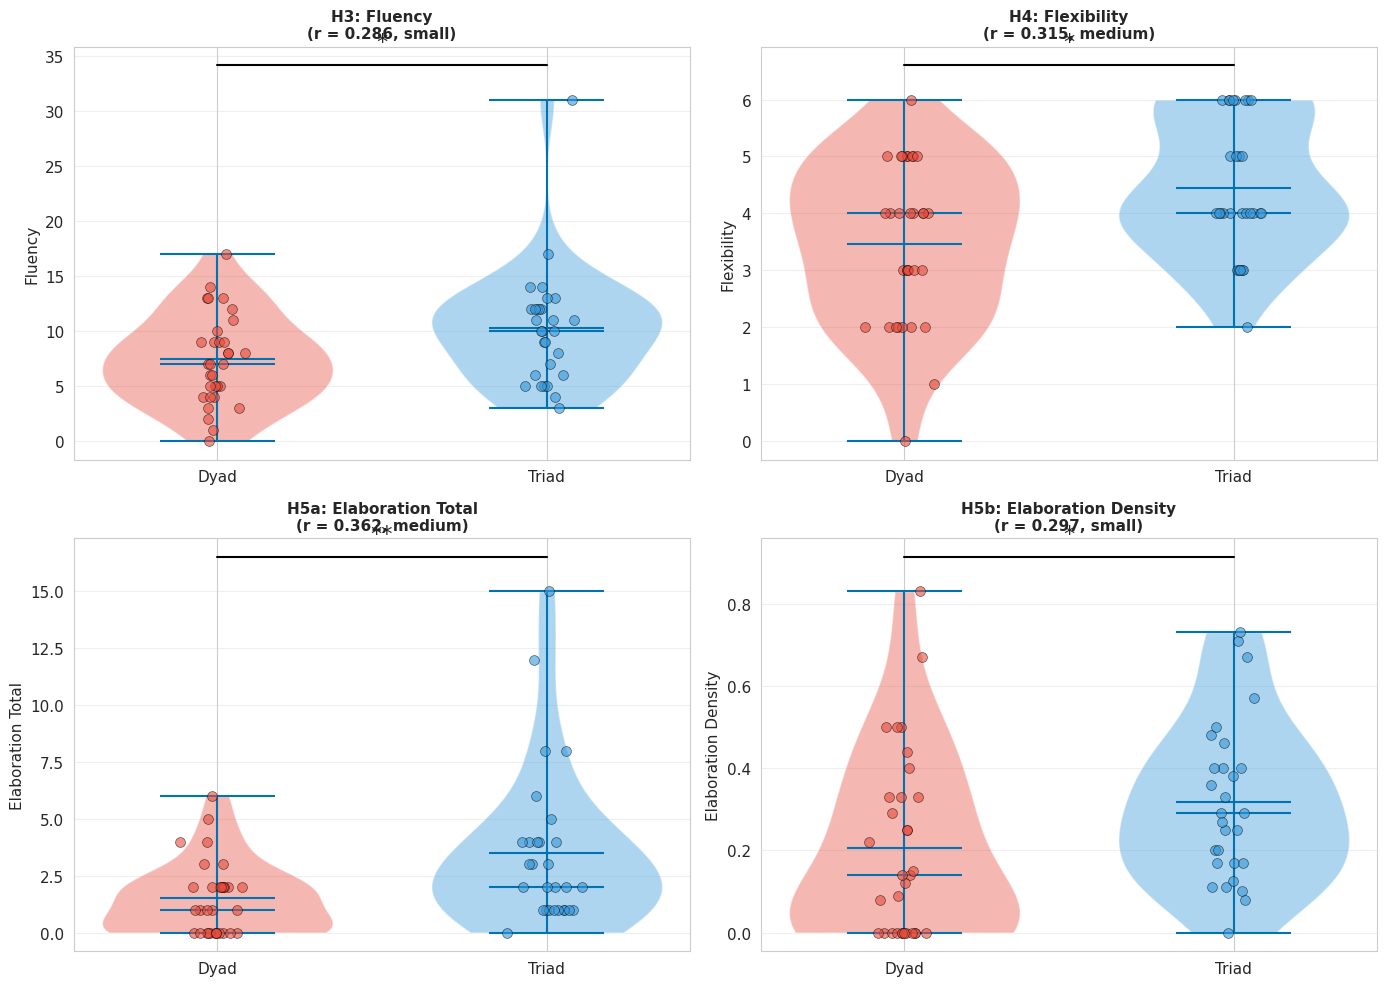

Violin plots saved as 'creativity_comparisons_violin.png'

Significance markers: *** p < .001, ** p < .01, * p < .05 (FDR-corrected)


In [21]:
# Create violin plots for all creativity metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, var in enumerate(creativity_vars):
    ax = axes[idx]
    
    # Violin plot
    parts = ax.violinplot(
        [df[df['session'] == 'dyad'][var].dropna(),
         df[df['session'] == 'triad'][var].dropna()],
        positions=[0, 1],
        showmeans=True,
        showmedians=True,
        widths=0.7
    )
    
    # Color the violins
    colors = ['#E74C3C', '#3498DB']  # Red for dyad, Blue for triad
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.4)
    
    # Add individual data points with jitter
    for condition_idx, condition in enumerate(['dyad', 'triad']):
        data = df[df['session'] == condition][var].dropna()
        x = np.random.normal(condition_idx, 0.04, size=len(data))
        ax.scatter(x, data, alpha=0.6, s=50, color=colors[condition_idx], 
                  edgecolors='black', linewidth=0.5, zorder=3)
    
    # Formatting
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Dyad', 'Triad'])
    ax.set_ylabel(var.replace('_', ' ').title())
    
    # Add significance stars if applicable
    result = results_summary[idx]
    if result['Significant_FDR']:
        y_max = df[var].max()
        if result['p_fdr_adjusted'] < 0.001:
            sig_text = '***'
        elif result['p_fdr_adjusted'] < 0.01:
            sig_text = '**'
        else:
            sig_text = '*'
        
        ax.plot([0, 1], [y_max * 1.1, y_max * 1.1], 'k-', linewidth=1.5)
        ax.text(0.5, y_max * 1.15, sig_text, ha='center', fontsize=16)
    
    # Add title with hypothesis and effect size
    title = f"{result['Hypothesis']}: {var.replace('_', ' ').title()}\n"
    title += f"({result['Effect_Size']}, {result['Effect_Magnitude']})"
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('creativity_comparisons_violin.png', dpi=300, bbox_inches='tight')
plt.show()

print("Violin plots saved as 'creativity_comparisons_violin.png'")
print("\nSignificance markers: *** p < .001, ** p < .01, * p < .05 (FDR-corrected)")

### 3.2 Bar Chart with Error Bars

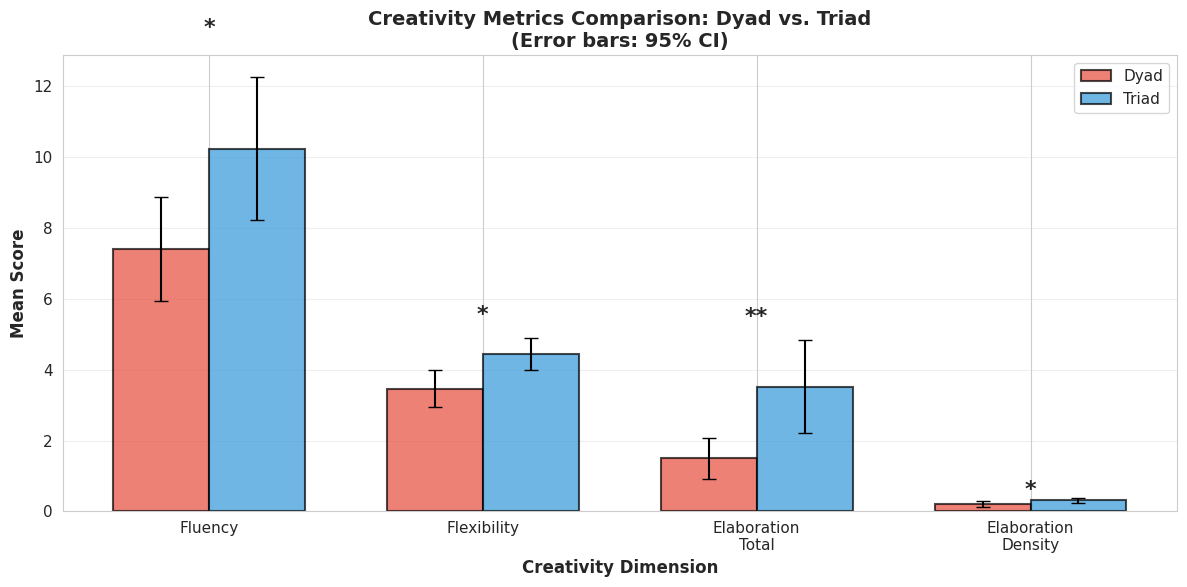

Bar chart saved as 'creativity_comparisons_bars.png'


In [22]:
# Create bar chart with 95% CI error bars
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data
x_pos = np.arange(len(creativity_vars))
bar_width = 0.35

dyad_means = [df[df['session'] == 'dyad'][var].mean() for var in creativity_vars]
triad_means = [df[df['session'] == 'triad'][var].mean() for var in creativity_vars]

# Calculate 95% CI
from scipy.stats import sem, t as t_dist

dyad_cis = []
triad_cis = []

for var in creativity_vars:
    dyad_data = df[df['session'] == 'dyad'][var].dropna()
    triad_data = df[df['session'] == 'triad'][var].dropna()
    
    dyad_ci = sem(dyad_data) * t_dist.ppf(0.975, len(dyad_data)-1)
    triad_ci = sem(triad_data) * t_dist.ppf(0.975, len(triad_data)-1)
    
    dyad_cis.append(dyad_ci)
    triad_cis.append(triad_ci)

# Create bars
bars1 = ax.bar(x_pos - bar_width/2, dyad_means, bar_width, 
               yerr=dyad_cis, capsize=5, label='Dyad',
               color='#E74C3C', alpha=0.7, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x_pos + bar_width/2, triad_means, bar_width,
               yerr=triad_cis, capsize=5, label='Triad',
               color='#3498DB', alpha=0.7, edgecolor='black', linewidth=1.5)

# Add significance stars
for idx, result in enumerate(results_summary):
    if result['Significant_FDR']:
        y_pos = max(dyad_means[idx] + dyad_cis[idx], triad_means[idx] + triad_cis[idx]) * 1.1
        
        if result['p_fdr_adjusted'] < 0.001:
            sig_text = '***'
        elif result['p_fdr_adjusted'] < 0.01:
            sig_text = '**'
        else:
            sig_text = '*'
        
        ax.text(idx, y_pos, sig_text, ha='center', fontsize=16, fontweight='bold')

# Formatting
ax.set_xlabel('Creativity Dimension', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Score', fontsize=12, fontweight='bold')
ax.set_title('Creativity Metrics Comparison: Dyad vs. Triad\n(Error bars: 95% CI)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([var.replace('_', '\n').title() for var in creativity_vars])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('creativity_comparisons_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print("Bar chart saved as 'creativity_comparisons_bars.png'")

## PHASE 4: Additional Analyses
### 4.1 Correlation Between Creativity Dimensions


CORRELATIONS BETWEEN CREATIVITY DIMENSIONS

Pearson Correlation Matrix:
                     fluency  flexibility  elaboration_total  \
fluency                1.000        0.744              0.710   
flexibility            0.744        1.000              0.501   
elaboration_total      0.710        0.501              1.000   
elaboration_density    0.190        0.188              0.713   

                     elaboration_density  
fluency                            0.190  
flexibility                        0.188  
elaboration_total                  0.713  
elaboration_density                1.000  


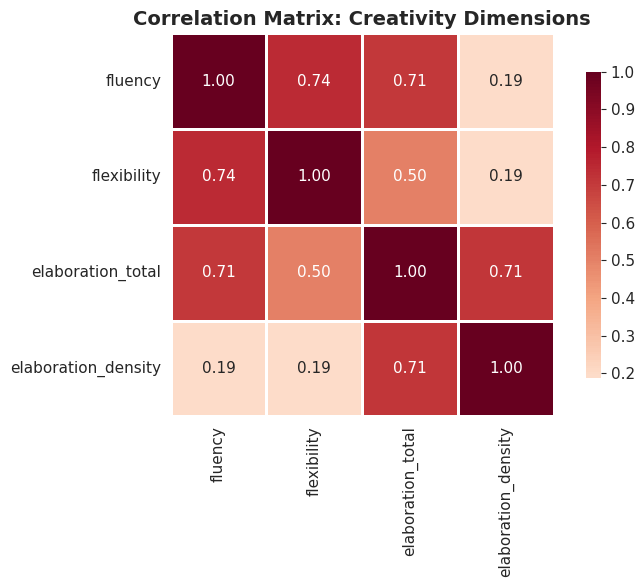


Correlation heatmap saved as 'creativity_correlation_matrix.png'

Significance Tests:
------------------------------------------------------------
fluency              × flexibility          : r =  0.744, p = 0.0000 ***
fluency              × elaboration_total    : r =  0.710, p = 0.0000 ***
fluency              × elaboration_density  : r =  0.190, p = 0.1430 ns
flexibility          × elaboration_total    : r =  0.501, p = 0.0000 ***
flexibility          × elaboration_density  : r =  0.188, p = 0.1468 ns
elaboration_total    × elaboration_density  : r =  0.713, p = 0.0000 ***


In [23]:
# Correlation matrix for creativity dimensions
print("\n" + "="*60)
print("CORRELATIONS BETWEEN CREATIVITY DIMENSIONS")
print("="*60)

# Calculate correlations
corr_matrix = df[creativity_vars].corr()

print("\nPearson Correlation Matrix:")
print(corr_matrix.round(3))

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Creativity Dimensions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('creativity_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation heatmap saved as 'creativity_correlation_matrix.png'")

# Test significance of correlations
print("\nSignificance Tests:")
print("-" * 60)

for i, var1 in enumerate(creativity_vars):
    for var2 in creativity_vars[i+1:]:
        r, p = pearsonr(df[var1].dropna(), df[var2].dropna())
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
        print(f"{var1:20} × {var2:20} : r = {r:6.3f}, p = {p:.4f} {sig}")

### 4.2 Quality Flag Analysis

In [24]:
# Analyze impact of quality flags on results
print("\n" + "="*60)
print("SENSITIVITY ANALYSIS: QUALITY FLAGS")
print("="*60)

# Compare results with and without flagged sessions
df_clean = df[~df['any_quality_flag']].copy()

print(f"\nOriginal sample: N = {len(df)}")
print(f"Clean sample (no quality flags): N = {len(df_clean)}")
print(f"Removed: {len(df) - len(df_clean)} sessions ({((len(df) - len(df_clean))/len(df)*100):.1f}%)")

print("\nComparison of Results (Clean Sample Only):")
print("-" * 60)

for var in creativity_vars:
    dyad_clean = df_clean[df_clean['session'] == 'dyad'][var].dropna()
    triad_clean = df_clean[df_clean['session'] == 'triad'][var].dropna()
    
    if len(dyad_clean) > 0 and len(triad_clean) > 0:
        # Run test on clean data
        if test_decisions[var] == 'mann_whitney':
            u_stat, p_val = mannwhitneyu(triad_clean, dyad_clean, alternative='greater')
            print(f"\n{var.replace('_', ' ').title()}:")
            print(f"  Clean sample: U = {u_stat:.1f}, p = {p_val:.4f}")
        else:
            equal_var = (test_decisions[var] == 'ttest_equal')
            t_stat, p_val = ttest_ind(triad_clean, dyad_clean, equal_var=equal_var)
            p_val = p_val / 2  # One-tailed
            print(f"\n{var.replace('_', ' ').title()}:")
            print(f"  Clean sample: t = {t_stat:.3f}, p = {p_val:.4f}")
        
        # Compare to original
        original_p = results_summary[[r['Variable'] for r in results_summary].index(var)]['p_one_tailed']
        print(f"  Original sample: p = {original_p:.4f}")
        print(f"  Difference: {abs(p_val - original_p):.4f}")
    else:
        print(f"\n{var.replace('_', ' ').title()}: Insufficient data in clean sample")


SENSITIVITY ANALYSIS: QUALITY FLAGS

Original sample: N = 61
Clean sample (no quality flags): N = 26
Removed: 35 sessions (57.4%)

Comparison of Results (Clean Sample Only):
------------------------------------------------------------

Fluency:
  Clean sample: U = 83.5, p = 0.4364
  Original sample: p = 0.0128
  Difference: 0.4236

Flexibility:
  Clean sample: U = 85.5, p = 0.3896
  Original sample: p = 0.0059
  Difference: 0.3837

Elaboration Total:
  Clean sample: U = 93.5, p = 0.2432
  Original sample: p = 0.0020
  Difference: 0.2411

Elaboration Density:
  Clean sample: U = 91.5, p = 0.2808
  Original sample: p = 0.0101
  Difference: 0.2707


### 4.3 Composite Creativity Score


COMPOSITE CREATIVITY SCORE ANALYSIS

Composite Score Descriptives:
------------------------------------------------------------
Dyad:  M = -0.302, SD = 0.647
Triad: M = 0.333, SD = 0.832

Inferential Statistics:
  t(59) = 3.342
  p (one-tailed) = 0.0007
  Cohen's d = 0.857 (large)

  ✓ Triad shows significantly higher OVERALL CREATIVITY than Dyad.


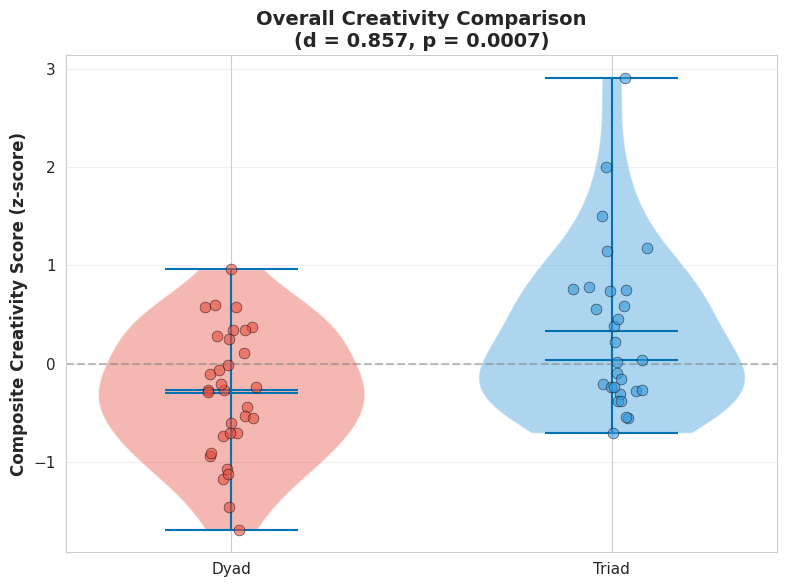


Composite score plot saved as 'composite_creativity_comparison.png'


In [25]:
# Create composite creativity score
print("\n" + "="*60)
print("COMPOSITE CREATIVITY SCORE ANALYSIS")
print("="*60)

# Standardize each dimension (z-scores)
from scipy.stats import zscore

for var in creativity_vars:
    df[f'{var}_z'] = zscore(df[var].dropna())

# Calculate composite score (mean of z-scores)
z_vars = [f'{var}_z' for var in creativity_vars]
df['creativity_composite'] = df[z_vars].mean(axis=1)

print("\nComposite Score Descriptives:")
print("-" * 60)

dyad_composite = df[df['session'] == 'dyad']['creativity_composite'].dropna()
triad_composite = df[df['session'] == 'triad']['creativity_composite'].dropna()

print(f"Dyad:  M = {dyad_composite.mean():.3f}, SD = {dyad_composite.std():.3f}")
print(f"Triad: M = {triad_composite.mean():.3f}, SD = {triad_composite.std():.3f}")

# Test composite score
t_stat, p_two = ttest_ind(triad_composite, dyad_composite)
p_one = p_two / 2
d = cohens_d(dyad_composite, triad_composite)

print("\nInferential Statistics:")
print(f"  t({len(dyad_composite) + len(triad_composite) - 2}) = {t_stat:.3f}")
print(f"  p (one-tailed) = {p_one:.4f}")
print(f"  Cohen's d = {d:.3f} ({interpret_effect_size(d, 'd')})")

if p_one < 0.05:
    print("\n  ✓ Triad shows significantly higher OVERALL CREATIVITY than Dyad.")
else:
    print("\n  ✗ No significant difference in overall creativity between conditions.")

# Visualize composite scores
fig, ax = plt.subplots(figsize=(8, 6))

parts = ax.violinplot(
    [dyad_composite, triad_composite],
    positions=[0, 1],
    showmeans=True,
    showmedians=True,
    widths=0.7
)

for pc, color in zip(parts['bodies'], ['#E74C3C', '#3498DB']):
    pc.set_facecolor(color)
    pc.set_alpha(0.4)

# Add individual points
for idx, (data, color) in enumerate([(dyad_composite, '#E74C3C'), 
                                      (triad_composite, '#3498DB')]):
    x = np.random.normal(idx, 0.04, size=len(data))
    ax.scatter(x, data, alpha=0.6, s=60, color=color, 
              edgecolors='black', linewidth=0.5, zorder=3)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Dyad', 'Triad'])
ax.set_ylabel('Composite Creativity Score (z-score)', fontsize=12, fontweight='bold')
ax.set_title(f'Overall Creativity Comparison\n(d = {d:.3f}, p = {p_one:.4f})', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('composite_creativity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComposite score plot saved as 'composite_creativity_comparison.png'")

## PHASE 5: APA-Style Results Write-Up

In [27]:
# Generate APA-style results text
print("\n" + "="*70)
print("APA-STYLE RESULTS WRITE-UP")
print("="*70)
print("\nCopy the text below for your dissertation results section:\n")
print("="*70)

results_text = """
## Results: Study 2 - Verbal Creativity Analysis

### Descriptive Statistics

Creativity metrics were analyzed for {n_total} children ({n_dyad} in the dyad 
condition, {n_triad} in the triad condition). Table X presents descriptive 
statistics for all four creativity dimensions by facilitation condition.

[INSERT TABLE HERE]

### Hypothesis Testing

To test hypotheses H3-H6, we compared creativity scores between conditions 
using {test_description}. All p-values were adjusted for multiple comparisons 
using the False Discovery Rate (FDR) method (Benjamini & Hochberg, 1995).

""".format(
    n_total=len(df),
    n_dyad=len(df[df['session'] == 'dyad']),
    n_triad=len(df[df['session'] == 'triad']),
    test_description="independent t-tests and Mann-Whitney U tests as appropriate"
)

# Add results for each hypothesis
for result in results_summary:
    var = result['Variable']
    h_num = result['Hypothesis']
    
    dyad_data = df[df['session'] == 'dyad'][var].dropna()
    triad_data = df[df['session'] == 'triad'][var].dropna()
    
    if result['Significant_FDR']:
        results_text += f"""
**{h_num} ({var.replace('_', ' ').title()})**: Children in the triad condition 
(M = {triad_data.mean():.2f}, SD = {triad_data.std():.2f}) demonstrated significantly 
higher {var.replace('_', ' ')} than children in the dyad condition 
(M = {dyad_data.mean():.2f}, SD = {dyad_data.std():.2f}), {result['Statistic']}, 
p = {result['p_fdr_adjusted']:.3f}, {result['Effect_Size']}. This represents a 
{result['Effect_Magnitude']} effect size, supporting {h_num}.
"""
    else:
        results_text += f"""
**{h_num} ({var.replace('_', ' ').title()})**: No significant difference was found 
between the dyad condition (M = {dyad_data.mean():.2f}, SD = {dyad_data.std():.2f}) 
and triad condition (M = {triad_data.mean():.2f}, SD = {triad_data.std():.2f}), 
{result['Statistic']}, p = {result['p_fdr_adjusted']:.3f}, {result['Effect_Size']}. 
{h_num} was not supported.
"""

# Add composite score results
results_text += f"""
### Overall Creativity

A composite creativity score was calculated by averaging standardized scores 
across all four dimensions. {"The triad condition showed significantly higher overall creativity " + 
f"(M = {triad_composite.mean():.2f}, SD = {triad_composite.std():.2f}) compared to the dyad " +
f"condition (M = {dyad_composite.mean():.2f}, SD = {dyad_composite.std():.2f}), " +
f"t({len(dyad_composite) + len(triad_composite) - 2}) = {t_stat:.2f}, p = {p_one:.3f}, d = {d:.2f}." 
if p_one < 0.05 else 
f"No significant difference in overall creativity was observed between the dyad " +
f"(M = {dyad_composite.mean():.2f}, SD = {dyad_composite.std():.2f}) and triad " +
f"(M = {triad_composite.mean():.2f}, SD = {triad_composite.std():.2f}) conditions, " +
f"t({len(dyad_composite) + len(triad_composite) - 2}) = {t_stat:.2f}, p = {p_one:.3f}, d = {d:.2f}."}
"""

print(results_text)
print("="*70)

# Save to text file
with open('study2_apa_results_writeup.txt', 'w') as f:
    f.write(results_text)

print("\nAPA-style write-up saved to 'study2_apa_results_writeup.txt'")


APA-STYLE RESULTS WRITE-UP

Copy the text below for your dissertation results section:


## Results: Study 2 - Verbal Creativity Analysis

### Descriptive Statistics

Creativity metrics were analyzed for 61 children (32 in the dyad 
condition, 29 in the triad condition). Table X presents descriptive 
statistics for all four creativity dimensions by facilitation condition.

[INSERT TABLE HERE]

### Hypothesis Testing

To test hypotheses H3-H6, we compared creativity scores between conditions 
using independent t-tests and Mann-Whitney U tests as appropriate. All p-values were adjusted for multiple comparisons 
using the False Discovery Rate (FDR) method (Benjamini & Hochberg, 1995).


**H3 (Fluency)**: Children in the triad condition 
(M = 10.24, SD = 5.32) demonstrated significantly 
higher fluency than children in the dyad condition 
(M = 7.41, SD = 4.05), U = 618.5, 
p = 0.013, r = 0.286. This represents a 
small effect size, supporting H3.

**H4 (Flexibility)**: Children in the tri

## PHASE 6: Create Summary Table for Dissertation

In [28]:
# Create publication-ready table
print("\n" + "="*70)
print("TABLE FOR DISSERTATION")
print("="*70)

# Prepare table data
table_data = []

for var in creativity_vars:
    dyad_data = df[df['session'] == 'dyad'][var].dropna()
    triad_data = df[df['session'] == 'triad'][var].dropna()
    
    result = [r for r in results_summary if r['Variable'] == var][0]
    
    table_data.append({
        'Dimension': var.replace('_', ' ').title(),
        'Dyad M (SD)': f"{dyad_data.mean():.2f} ({dyad_data.std():.2f})",
        'Triad M (SD)': f"{triad_data.mean():.2f} ({triad_data.std():.2f})",
        'Test Statistic': result['Statistic'],
        'p (FDR)': f"{result['p_fdr_adjusted']:.3f}",
        'Effect Size': result['Effect_Size'],
        'Sig.': '✓' if result['Significant_FDR'] else ''
    })

table_df = pd.DataFrame(table_data)

print("\nTable X. Creativity Metrics by Facilitation Condition")
print("="*70)
print(table_df.to_string(index=False))
print("="*70)
print("Note: FDR = False Discovery Rate correction; ✓ indicates p < .05")

# Save as LaTeX table
latex_table = table_df.to_latex(index=False, caption="Creativity Metrics by Facilitation Condition")
with open('study2_results_table.tex', 'w') as f:
    f.write(latex_table)

# Save as CSV
table_df.to_csv('study2_results_table.csv', index=False)

print("\nTable saved as:")
print("  - study2_results_table.tex (LaTeX format)")
print("  - study2_results_table.csv (CSV format)")


TABLE FOR DISSERTATION

Table X. Creativity Metrics by Facilitation Condition
          Dimension Dyad M (SD) Triad M (SD) Test Statistic p (FDR) Effect Size Sig.
            Fluency 7.41 (4.05) 10.24 (5.32)      U = 618.5   0.013   r = 0.286    ✓
        Flexibility 3.47 (1.41)  4.45 (1.18)      U = 634.5   0.012   r = 0.315    ✓
  Elaboration Total 1.50 (1.61)  3.52 (3.46)      U = 660.0   0.008   r = 0.362    ✓
Elaboration Density 0.21 (0.23)  0.32 (0.19)      U = 624.5   0.013   r = 0.297    ✓
Note: FDR = False Discovery Rate correction; ✓ indicates p < .05


ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

## Summary and Next Steps

In [ ]:
print("\n" + "="*70)
print("ANALYSIS COMPLETE - SUMMARY")
print("="*70)

print("\n✓ Files Generated:")
print("  1. study2_hypothesis_testing_results.csv")
print("  2. distributions_by_condition.png")
print("  3. creativity_comparisons_violin.png")
print("  4. creativity_comparisons_bars.png")
print("  5. creativity_correlation_matrix.png")
print("  6. composite_creativity_comparison.png")
print("  7. study2_apa_results_writeup.txt")
print("  8. study2_results_table.tex")
print("  9. study2_results_table.csv")

print("\n✓ Hypotheses Tested:")
for result in results_summary:
    status = "SUPPORTED" if result['Significant_FDR'] else "NOT SUPPORTED"
    print(f"  {result['Hypothesis']:6} ({result['Variable']:20}): {status}")

print("\n✓ Next Steps for Your Dissertation:")
print("  1. Integrate these results into Chapter 6 (Study 2 Results)")
print("  2. Cross-reference with Study 1 findings in Discussion (Chapter 7)")
print("  3. Add correlation analyses between Study 1 and Study 2 metrics")
print("  4. Consider age/AQ moderation analyses if you have that data")
print("  5. Use generated figures in your dissertation (high-res PNG files)")

print("\n" + "="*70)
print("Good luck with your dissertation! 🎓")
print("="*70)